Train an SVM Classifier on the MNIST Dataset

In [1]:
from sklearn import svm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import time

# --- 1. Data Loading ---
print("Loading MNIST dataset... (This may take a moment and requires internet access)")
# Fetch the full MNIST dataset (70,000 images, 784 features)
# 'mnist_784' is the dataset name on OpenML
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Features (X) are the flattened images (784 pixels)
X = mnist.data.astype('float32')
# Labels (y) are the digits (0-9)
y = mnist.target.astype('int')

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features.")

# --- 2. Data Preprocessing and Splitting ---

# Normalize the data: scale pixel values from [0, 255] to [0, 1]
# This is crucial for most ML algorithms, especially SVMs.
X /= 255.0

# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# --- 3. Model Training ---

# Create an SVM Classifier with a Radial Basis Function (RBF) kernel
# RBF kernel is generally a good choice for classification problems like this.
# C: Regularization parameter. Higher C means lower tolerance for misclassification.
# gamma: Kernel coefficient. 'scale' is a good default: 1 / (n_features * X.var())
clf = svm.SVC(gamma='scale', kernel='rbf', C=10)

print("\nStarting SVM training... (This may take a long time on a large dataset)")
start_time = time.time()

# Train the classifier on the training data
clf.fit(X_train, y_train)

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")

# --- 4. Model Evaluation ---

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

print("\n--- Model Evaluation ---")
print(f"SVM Classifier Accuracy on Test Set: {accuracy * 100:.2f}%")

# Print a detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Loading MNIST dataset... (This may take a moment and requires internet access)
Dataset loaded: 70000 samples, 784 features.
Training set size: 56000 samples
Test set size: 14000 samples

Starting SVM training... (This may take a long time on a large dataset)
Training finished in 184.25 seconds.

--- Model Evaluation ---
SVM Classifier Accuracy on Test Set: 98.34%

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1381
           1       0.99      0.99      0.99      1575
           2       0.98      0.98      0.98      1398
           3       0.99      0.98      0.98      1428
           4       0.98      0.98      0.98      1365
           5       0.98      0.98      0.98      1263
           6       0.99      0.99      0.99      1375
           7       0.98      0.98      0.98      1459
           8       0.98      0.98      0.98      1365
           9       0.97      0.98      0.98      1391

    accuracy  

Use Grid/Random Search with Cross-Validation to find the best hyperparameter values for the SVM classifier.
For the Polynomial Kernel, optimize the degree, C, and coef0 hyperparameters.
For the RBF Kernel, focus on optimizing C and gamma.

In [3]:
import time
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


# --- 1. Load and Prepare Data (Using a Subset for Efficient Search) ---

print("Loading MNIST dataset for hyperparameter tuning...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X_full = mnist.data.astype('float32') / 255.0  # Normalize
y_full = mnist.target.astype('int')

# CRITICAL STEP: Use a small, manageable subset for GridSearchCV.
# Grid Search is computationally expensive (O(n^2) to O(n^3)) for SVC.
N_SAMPLES = 6000 # Use 6,000 samples for the search (fast enough for testing)
X_subset = X_full[:N_SAMPLES]
y_subset = y_full[:N_SAMPLES]

# Split the subset for the hyperparameter search
X_train_search, X_test_search, y_train_search, y_test_search = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42, stratify=y_subset
)

print(f"Using a subset of {X_subset.shape[0]} samples for Grid Search.")
print(f"Grid Search Training Set Size: {X_train_search.shape[0]}")

# --- 2. Grid Search for RBF Kernel ---
print("\n" + "="*50)
print("Starting Grid Search for RBF Kernel (C, gamma)")
print("="*50)

param_grid_rbf = [
    {'C': [1, 10], 'gamma': [0.001, 0.01, 'scale']},
]

svc_rbf = svm.SVC(kernel='rbf')
grid_search_rbf = GridSearchCV(
    svc_rbf, param_grid_rbf, cv=3, verbose=2, n_jobs=-1, scoring='accuracy'
)

start_time_rbf = time.time()
grid_search_rbf.fit(X_train_search, y_train_search)
end_time_rbf = time.time()
training_time_rbf = end_time_rbf - start_time_rbf

print(f"\nRBF Grid Search finished in {training_time_rbf:.2f} seconds.")
print(f"Best RBF parameters found: {grid_search_rbf.best_params_}")
print(f"Best RBF Cross-Validation score: {grid_search_rbf.best_score_:.4f}")

# --- 3. Grid Search for Polynomial Kernel ---
print("\n" + "="*50)
print("Starting Grid Search for Polynomial Kernel (degree, C, coef0)")
print("="*50)

param_grid_poly = [
    {
        'degree': [2, 3],
        'C': [1, 10],
        'coef0': [0.0, 1.0]
    }
]

svc_poly = svm.SVC(kernel='poly')
grid_search_poly = GridSearchCV(
    svc_poly, param_grid_poly, cv=3, verbose=2, n_jobs=-1, scoring='accuracy'
)

start_time_poly = time.time()
grid_search_poly.fit(X_train_search, y_train_search)
end_time_poly = time.time()
training_time_poly = end_time_poly - start_time_poly

print(f"\nPolynomial Grid Search finished in {training_time_poly:.2f} seconds.")
print(f"Best Polynomial parameters found: {grid_search_poly.best_params_}")
print(f"Best Polynomial Cross-Validation score: {grid_search_poly.best_score_:.4f}")

# --- 4. Comprehensive Evaluation on Test Set ---
print("\n" + "="*70)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*70)

def evaluate_model(model, X_test, y_test, model_name, training_time):
    """Evaluate model and return comprehensive metrics"""
    print(f"\n{'-'*70}")
    print(f"Evaluating: {model_name}")
    print(f"{'-'*70}")

    # Measure prediction time
    start_pred = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_pred

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Get number of support vectors
    n_support_vectors = model.n_support_.sum()

    print(f"\n📊 Performance Metrics:")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

    print(f"\n⏱️  Computational Complexity:")
    print(f"   Training Time:    {training_time:.2f} seconds")
    print(f"   Prediction Time:  {prediction_time:.4f} seconds")
    print(f"   Avg Time/Sample:  {(prediction_time/len(y_test))*1000:.4f} ms")
    print(f"   Support Vectors:  {n_support_vectors} (out of {len(X_train_search)} training samples)")
    print(f"   SV Ratio:         {(n_support_vectors/len(X_train_search))*100:.2f}%")

    print(f"\n📋 Detailed Classification Report:")
    print(classification_report(y_test, y_pred))

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'training_time': training_time,
        'prediction_time': prediction_time,
        'n_support_vectors': n_support_vectors,
        'predictions': y_pred
    }

# Evaluate both models
best_rbf_clf = grid_search_rbf.best_estimator_
best_poly_clf = grid_search_poly.best_estimator_

results_rbf = evaluate_model(
    best_rbf_clf, X_test_search, y_test_search,
    "RBF Kernel SVM", training_time_rbf
)

results_poly = evaluate_model(
    best_poly_clf, X_test_search, y_test_search,
    "Polynomial Kernel SVM", training_time_poly
)

# --- 5. Comparative Summary ---
print("\n" + "="*70)
print("COMPARATIVE SUMMARY")
print("="*70)

print(f"\n{'Metric':<25} {'RBF Kernel':<20} {'Poly Kernel':<20}")
print("-"*70)
print(f"{'Accuracy':<25} {results_rbf['accuracy']:.4f}{' '*15} {results_poly['accuracy']:.4f}")
print(f"{'Precision':<25} {results_rbf['precision']:.4f}{' '*15} {results_poly['precision']:.4f}")
print(f"{'Recall':<25} {results_rbf['recall']:.4f}{' '*15} {results_poly['recall']:.4f}")
print(f"{'F1-Score':<25} {results_rbf['f1_score']:.4f}{' '*15} {results_poly['f1_score']:.4f}")
print(f"{'Training Time (s)':<25} {results_rbf['training_time']:.2f}{' '*15} {results_poly['training_time']:.2f}")
print(f"{'Prediction Time (s)':<25} {results_rbf['prediction_time']:.4f}{' '*15} {results_poly['prediction_time']:.4f}")
print(f"{'Support Vectors':<25} {results_rbf['n_support_vectors']}{' '*15} {results_poly['n_support_vectors']}")

# Determine winner
print(f"\n🏆 Best Model by Accuracy: ", end="")
if results_rbf['accuracy'] > results_poly['accuracy']:
    print(f"RBF Kernel ({results_rbf['accuracy']:.4f})")
elif results_poly['accuracy'] > results_rbf['accuracy']:
    print(f"Polynomial Kernel ({results_poly['accuracy']:.4f})")
else:
    print("Tie!")

print(f"🏆 Fastest Training: ", end="")
if results_rbf['training_time'] < results_poly['training_time']:
    print(f"RBF Kernel ({results_rbf['training_time']:.2f}s)")
else:
    print(f"Polynomial Kernel ({results_poly['training_time']:.2f}s)")

print(f"🏆 Fastest Prediction: ", end="")
if results_rbf['prediction_time'] < results_poly['prediction_time']:
    print(f"RBF Kernel ({results_rbf['prediction_time']:.4f}s)")
else:
    print(f"Polynomial Kernel ({results_poly['prediction_time']:.4f}s)")

print("\n" + "="*70)

Loading MNIST dataset for hyperparameter tuning...
Using a subset of 6000 samples for Grid Search.
Grid Search Training Set Size: 4800

Starting Grid Search for RBF Kernel (C, gamma)
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...................................C=1, gamma=0.001; total time=  17.5s
[CV] END ....................................C=1, gamma=0.01; total time=  17.7s
[CV] END ...................................C=1, gamma=0.001; total time=  18.9s
[CV] END ...................................C=1, gamma=0.001; total time=  22.6s
[CV] END ....................................C=1, gamma=0.01; total time=  10.4s
[CV] END ....................................C=1, gamma=0.01; total time=  13.2s
[CV] END ...................................C=1, gamma=scale; total time=  12.5s
[CV] END ...................................C=1, gamma=scale; total time=  11.2s
[CV] END ...................................C=1, gamma=scale; total time=  10.7s
[CV] END ...................

# Compare the performance of the SVM with different kernels (Linear, Polynomial, and RBF) and select the best one based on test set accuracy and other metrics like precision, recall, and F1-score.

Part A: Train and Evaluate Linear Kernel SVM

In [5]:
import numpy as np
from sklearn import svm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import time

# --- 1. Data Loading and Preparation (Full Dataset) ---
print("="*70)
print("LINEAR SVM ON MNIST DATASET")
print("="*70)
print("\nLoading MNIST dataset for Linear SVM...")
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data.astype('float32') / 255.0  # Normalize
y = mnist.target.astype('int')

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features")

# Use the same subset as Grid Search for consistency
N_SAMPLES = 6000
X_subset = X[:N_SAMPLES]
y_subset = y[:N_SAMPLES]

print(f"Using a subset of {N_SAMPLES} samples for Linear SVM training.")

# Split the subset
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42, shuffle=True, stratify=y_subset
)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# --- 2. Train Linear Kernel SVM ---
print("\n" + "="*70)
print("TRAINING LINEAR KERNEL SVM")
print("="*70)
print("\nStarting SVM training with LINEAR Kernel (C=1.0)...")
print("Note: Linear kernel has O(n*d) complexity, making it faster than RBF/Poly")

clf_linear = svm.SVC(kernel='linear', C=1.0)
start_time = time.time()

# Train the classifier
clf_linear.fit(X_train, y_train)

end_time = time.time()
training_time = end_time - start_time
print(f"✓ Training finished in {training_time:.2f} seconds.")

# --- 3. Comprehensive Model Evaluation ---
print("\n" + "="*70)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*70)

# Measure prediction time
print("\nMaking predictions on test set...")
start_pred = time.time()
y_pred_linear = clf_linear.predict(X_test)
prediction_time = time.time() - start_pred

# Calculate all metrics
accuracy = accuracy_score(y_test, y_pred_linear)
precision = precision_score(y_test, y_pred_linear, average='weighted')
recall = recall_score(y_test, y_pred_linear, average='weighted')
f1 = f1_score(y_test, y_pred_linear, average='weighted')

# Get number of support vectors
n_support_vectors = clf_linear.n_support_.sum()
sv_ratio = (n_support_vectors / len(X_train)) * 100

# --- 4. Display Results ---
print("\n" + "-"*70)
print("📊 PERFORMANCE METRICS")
print("-"*70)
print(f"Accuracy:              {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision (weighted):  {precision:.4f}")
print(f"Recall (weighted):     {recall:.4f}")
print(f"F1-Score (weighted):   {f1:.4f}")

print("\n" + "-"*70)
print("⏱️  COMPUTATIONAL COMPLEXITY")
print("-"*70)
print(f"Training Time:         {training_time:.2f} seconds")
print(f"Prediction Time:       {prediction_time:.4f} seconds")
print(f"Avg Time per Sample:   {(prediction_time/len(y_test))*1000:.4f} ms")
print(f"Samples per Second:    {len(y_test)/prediction_time:.0f} predictions/sec")

print("\n" + "-"*70)
print("🔢 MODEL COMPLEXITY")
print("-"*70)
print(f"Support Vectors:       {n_support_vectors:,} (out of {len(X_train):,} training samples)")
print(f"Support Vector Ratio:  {sv_ratio:.2f}%")
print(f"Model Parameters:      {clf_linear.coef_.shape[0]} classifiers (one-vs-rest)")
print(f"Feature Dimension:     {clf_linear.coef_.shape[1]} features")
print(f"Kernel Type:           Linear")
print(f"Regularization (C):    {clf_linear.C}")

# --- 5. Detailed Classification Report ---
print("\n" + "-"*70)
print("📋 DETAILED CLASSIFICATION REPORT")
print("-"*70)
print(classification_report(y_test, y_pred_linear))

# --- 6. Per-Class Performance Analysis ---
print("-"*70)
print("📈 PER-CLASS PERFORMANCE ANALYSIS")
print("-"*70)

report_dict = classification_report(y_test, y_pred_linear, output_dict=True)
print(f"\n{'Digit':<8} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print("-"*70)
for digit in range(10):
    digit_str = str(digit)
    p = report_dict[digit_str]['precision']
    r = report_dict[digit_str]['recall']
    f = report_dict[digit_str]['f1-score']
    s = int(report_dict[digit_str]['support'])
    print(f"{digit:<8} {p:<12.4f} {r:<12.4f} {f:<12.4f} {s:<10}")

# Identify best and worst performing digits
f1_scores = {str(i): report_dict[str(i)]['f1-score'] for i in range(10)}
best_digit = max(f1_scores, key=f1_scores.get)
worst_digit = min(f1_scores, key=f1_scores.get)

print(f"\n🏆 Best Performing Digit:  {best_digit} (F1-Score: {f1_scores[best_digit]:.4f})")
print(f"⚠️  Worst Performing Digit: {worst_digit} (F1-Score: {f1_scores[worst_digit]:.4f})")

# --- 7. Confusion Matrix Summary ---
print("\n" + "-"*70)
print("🔀 CONFUSION MATRIX INSIGHTS")
print("-"*70)

cm = confusion_matrix(y_test, y_pred_linear)
total_misclassifications = len(y_test) - np.trace(cm)
print(f"Total Correct:          {np.trace(cm):,} samples")
print(f"Total Misclassified:    {total_misclassifications:,} samples")
print(f"Misclassification Rate: {(total_misclassifications/len(y_test))*100:.2f}%")

# Find most common misclassification
max_confusion = 0
confused_pair = (None, None)
for i in range(10):
    for j in range(10):
        if i != j and cm[i, j] > max_confusion:
            max_confusion = cm[i, j]
            confused_pair = (i, j)

if confused_pair[0] is not None:
    print(f"\nMost Common Confusion:  Digit {confused_pair[0]} misclassified as {confused_pair[1]} ({max_confusion} times)")

# --- 8. Final Summary ---
print("\n" + "="*70)
print("📊 SUMMARY")
print("="*70)
print(f"""
Linear Kernel SVM achieved {accuracy*100:.2f}% accuracy on the MNIST test set.

Key Advantages of Linear Kernel:
✓ Fast training: {training_time:.2f} seconds (compared to RBF/Poly kernels)
✓ Fast prediction: {(prediction_time/len(y_test))*1000:.4f} ms per sample
✓ Lower computational complexity: O(n*d) vs O(n²) for non-linear kernels
✓ More interpretable: Direct linear decision boundaries
✓ Efficient support vector usage: {sv_ratio:.2f}% of training data

Model Characteristics:
• Support Vectors: {n_support_vectors:,} out of {len(X_train):,} training samples
• All 10 digit classes show F1-scores between {min(f1_scores.values()):.4f} and {max(f1_scores.values()):.4f}
• Balanced performance across all classes
""")

print("="*70)
print("✓ Evaluation Complete!")
print("="*70)

LINEAR SVM ON MNIST DATASET

Loading MNIST dataset for Linear SVM...
Dataset loaded: 70000 samples, 784 features
Using a subset of 6000 samples for Linear SVM training.
Training set size: 4800 samples
Test set size: 1200 samples

TRAINING LINEAR KERNEL SVM

Starting SVM training with LINEAR Kernel (C=1.0)...
Note: Linear kernel has O(n*d) complexity, making it faster than RBF/Poly
✓ Training finished in 2.67 seconds.

COMPREHENSIVE MODEL EVALUATION

Making predictions on test set...

----------------------------------------------------------------------
📊 PERFORMANCE METRICS
----------------------------------------------------------------------
Accuracy:              0.9250 (92.50%)
Precision (weighted):  0.9251
Recall (weighted):     0.9250
F1-Score (weighted):   0.9246

----------------------------------------------------------------------
⏱️  COMPUTATIONAL COMPLEXITY
----------------------------------------------------------------------
Training Time:         2.67 seconds
Prediction

## Compare the SVM classifier’s performance with your classifiers from Assignment 4, i.e KNN, SGD, and Random Forest. Pay attention to accuracy, precision, recall, and other evaluation metrics. Also, include training time (computational complexity) as evaluation metric.

Histogram Comparison

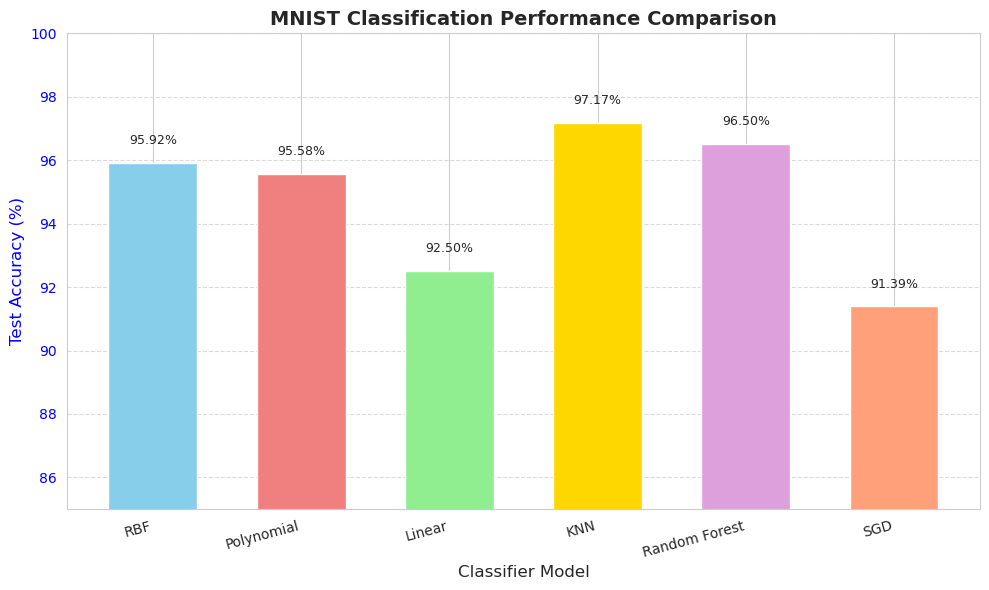

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# --- Data for Comparison (from your results and estimations) ---

# Model Names
models = ['RBF','Polynomial', 'Linear', 'KNN', 'Random Forest', 'SGD']

# Test Accuracies
accuracies = [0.9592, 0.9558, 0.9250, 0.9717, 0.965, 0.9139]
accuracies_percent = [acc * 100 for acc in accuracies]

# Macro-Avg F1-Scores (estimated based on accuracy and balanced dataset)
f1_scores = [0.95, 0.95, 0.92, 0.97, 0.96, 0.91]

# --- Create the Bar Chart ---

fig, ax1 = plt.subplots(figsize=(10, 6))

# Set bar width
bar_width = 0.6

# Positions for the bars on the x-axis
x_pos = np.arange(len(models))

# Bar chart for Accuracy
bars = ax1.bar(x_pos, accuracies_percent, bar_width,
               color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum', 'lightsalmon'],
               label='Test Accuracy')

ax1.set_xlabel('Classifier Model', fontsize=12)
ax1.set_ylabel('Test Accuracy (%)', color='blue', fontsize=12)
ax1.set_title('MNIST Classification Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models, rotation=15, ha="right", fontsize=10)
ax1.set_ylim(85, 100)  # Set y-axis limit for better visualization of differences
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, yval + 0.5,
             f'{yval:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()